In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

df1 = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/Three5xFAD_plaque_gene_MRI_merged_plaquedetectionregions_updated_updated.csv")
df2 = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/Three5xFAD_oligo_gene_MRI_merged_comparisonregions_cortex.csv")

df = pd.concat(
    [df1, df2.iloc[:, 26:]],  # 27th column → end (0-based index)
    axis=1
)
df = pd.read_csv("ThreeFAD_plaqueANDoligo_gene_MRI_merged.csv")

# Subtables
df_plaque = df[df["plaque_mask"] == 1]
df_noplaque = df[df["plaque_mask"] == 0]

# # Save
# df_plaque.to_csv("ThreeFAD_plaqueANDoligo_gene_subtable_plaque_cortex.csv", index=False)
# df_noplaque.to_csv("ThreeFAD_plaqueANDoligo_gene_subtable_noplaque_cortex.csv", index=False)

# print("Saved plaque and noplaque subtables.")
print("Plaque spots:", len(df_plaque))
print("No-plaque spots:", len(df_noplaque))
# df_selected = df[df["sampleID"] != "8577-FAD"]
# df_selected.to_csv("ThreeFAD_plaqueANDoligo_gene_MRI_merged_no8577.csv", index=False)

Plaque spots: 104
No-plaque spots: 1896


In [171]:
tmp = df.groupby("sampleID")["plaque_mask"].sum()
print("sampleIDs with any plaque:", (tmp > 0).sum(), "out of", tmp.shape[0])


sampleIDs with any plaque: 3 out of 3


In [25]:
mri_cols = df.columns[0:15]

plaque_mean = df_plaque[mri_cols].mean()
noplaque_mean = df_noplaque[mri_cols].mean()

plaque_sem = df_plaque[mri_cols].std()
noplaque_sem = df_noplaque[mri_cols].std()

print(plaque_mean)
print(plaque_sem)
print(noplaque_mean)
print(noplaque_sem)

x = np.arange(len(mri_cols))
width = 0.35

plt.figure(figsize=(10, 5))

plt.bar(x - width/2, plaque_mean, width, yerr=plaque_sem,
        label="Plaque", capsize=4)
plt.bar(x + width/2, noplaque_mean, width, yerr=noplaque_sem,
        label="No-plaque", capsize=4)

plt.xticks(x, mri_cols, rotation=45, ha="right")
plt.ylabel("Mean Value")
plt.title("MRI Features: Plaque vs No-plaque")
plt.legend()

plt.tight_layout()
plt.savefig("ThreeFAD_MRI_barplot_plaqueVSnoplaque.png", dpi=300)
plt.close()

print("Saved MRI barplot: MRI_barplot.png")


AD          0.354333
FA          0.143061
MD          0.310040
RD          0.287894
NDI         0.568973
ODI         0.622235
AK          0.758921
KFA         0.210817
MKT         0.821578
RTK         0.858569
Fextra      0.128862
Fneurite    0.411033
Fsoma       0.460105
Rsoma       5.751849
QSM        -0.010946
dtype: float64
AD          0.032855
FA          0.067039
MD          0.024809
RD          0.028383
NDI         0.073091
ODI         0.137688
AK          0.102096
KFA         0.082296
MKT         0.110567
RTK         0.119154
Fextra      0.046605
Fneurite    0.095069
Fsoma       0.079039
Rsoma       0.186555
QSM         0.019237
dtype: float64
AD          0.366179
FA          0.140031
MD          0.321461
RD          0.299102
NDI         0.542375
ODI         0.619222
AK          0.726090
KFA         0.208186
MKT         0.788290
RTK         0.821067
Fextra      0.141829
Fneurite    0.371920
Fsoma       0.485344
Rsoma       5.799729
QSM         0.000891
dtype: float64
AD        

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


results = []
gene_cols = df_plaque.columns[26:]  # columns 26:end
for gene in gene_cols:
    x1 = df_plaque[gene].dropna().values
    x0 = df_noplaque[gene].dropna().values
    # remove NaNs
    x1 = x1[~np.isnan(x1)]
    x0 = x0[~np.isnan(x0)]
    
    # x1 = x1 + 1e-9
    # x0 = x0 + 1e-9

    # # skip genes with no data
    # if len(x1) == 0 or len(x0) == 0:
    #     log2fc = nan
    #     p = nan
    #     continue

    # Welch t-test
    stat, p = ttest_ind(x1, x0, equal_var=False)
    

    # log2 fold change (add epsilon to avoid log(0))
    mean1 = np.mean(x1)
    mean0 = np.mean(x0)
    
    # if mean1 <= 0.01:
    #     continue   # skip this gene
    eps = 1e-9

    log2fc = np.log2((mean1 + eps) / (mean0 + eps))

    results.append([gene, mean1, mean0, log2fc, p])

stats_df = pd.DataFrame(
    results,
    columns=["gene_id", "mean_plaque", "mean_noplaque", "log2FC", "pval"]
)
stats_df = stats_df.dropna()
pvals = stats_df["pval"]
valid = np.isfinite(pvals)

pvals_fdr = np.full_like(pvals, np.nan)

reject, pvals_fdr[valid], _, _ = multipletests(
    pvals[valid],
    alpha=0.05,
    method="fdr_bh"
)

stats_df["FDR"] = pvals_fdr[valid]


stats_df.to_csv("plaque_vs_noplaque_plaqueANDoligo_genes_stats_including0s.csv", index=False)

Sig FDR: 1


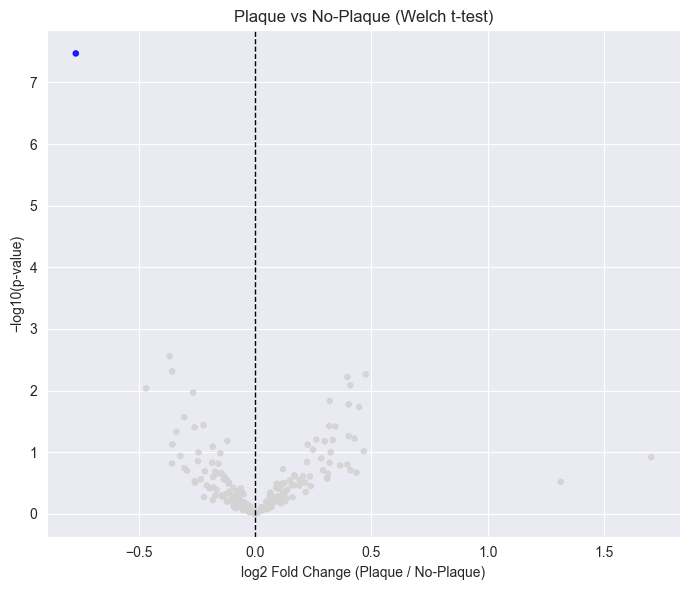

In [7]:
import matplotlib.pyplot as plt

stats_df = stats_df[stats_df["log2FC"] >= -10]

stats_df["neglog10p"] = -np.log10(stats_df["pval"].clip(1e-300))

stats_df["color"] = "lightgray"
print("Sig FDR:",len(stats_df.loc[(stats_df.FDR < 0.05)]))
stats_df.loc[(stats_df.FDR < 0.05) & (stats_df.log2FC > 0), "color"] = "red"
stats_df.loc[(stats_df.FDR < 0.05) & (stats_df.log2FC < 0), "color"] = "blue"

# cap fold-change for visualization only
stats_df["log2FC_plot"] = stats_df["log2FC"].clip(-8, 8)

plt.figure(figsize=(7, 6))

plt.scatter(
    stats_df["log2FC_plot"],
    stats_df["neglog10p"],
    c=stats_df["color"],
    s=14,
    alpha=0.85
)

# plt.axhline(-np.log10(0.05), ls="--", lw=1, c="black")
plt.axvline(0, ls="--", lw=1, c="black")

plt.xlabel("log2 Fold Change (Plaque / No-Plaque)")
plt.ylabel("−log10(p-value)")
plt.title("Plaque vs No-Plaque (Welch t-test)")

plt.tight_layout()
# plt.savefig("volcano_plaque_vs_all_gene_including0s_FDR_welch_2.png", dpi=300)
plt.show()


In [8]:
stats_df = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/significant_plaqueANDoligo_gene_expression_stats_allsample.csv")
top_up = stats_df[(stats_df.FDR < 0.05) & (stats_df.log2FC > 0)] \
            .sort_values("log2FC", ascending=False).head(10)

top_down = stats_df[(stats_df.FDR < 0.05) & (stats_df.log2FC < 0)] \
            .sort_values("log2FC").head(10)

top_up.to_csv("Top10_up_genes_new.csv",index=False)
top_down.to_csv("Top10_down_genes_new.csv",index=False)

In [9]:
sig_up = stats_df[(stats_df.pval < 0.05) & (stats_df.log2FC > 0)] \
            .sort_values("pval")

sig_down = stats_df[(stats_df.pval < 0.05) & (stats_df.log2FC < 0)] \
            .sort_values("pval")

sig_up.to_csv("Significant_up_genes_sortedbyp_new.csv",index=False)
sig_down.to_csv("Significant_down_genes_sortedbyp_new.csv",index=False)

In [ ]:
def permutation_pval(a, b, n_perm=1000):
    obs = np.mean(a) - np.mean(b)
    pooled = np.concatenate([a, b])
    count = 0
    for _ in range(n_perm):
        np.random.shuffle(pooled)
        diff = pooled[:len(a)].mean() - pooled[len(a):].mean()
        count += abs(diff) >= abs(obs)
    return (count + 1) / (n_perm + 1)


In [99]:
def p_to_star(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

outdir = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/MRI_voilin"
os.makedirs(outdir, exist_ok=True)

mri_cols = df_plaque.columns[0:15]

for col in mri_cols:

    # Extract data
    x = df_plaque[col].dropna().values
    y = df_noplaque[col].dropna().values

    # Welch t-test
    _, pval = ttest_ind(x, y, equal_var=False)
    star = p_to_star(pval)

    # Long-format dataframe
    df_plot = pd.DataFrame({
        "value": np.concatenate([x, y]),
        "group": ["Plaque"] * len(x) + ["No-Plaque"] * len(y)
    })

    # Plot
    plt.figure(figsize=(3.5, 4))

    sns.violinplot(
        data=df_plot,
        x="group",
        y="value",
        inner=None,
        cut=0,
        palette={"Plaque": "red", "No-Plaque": "gray"}
    )

    # sns.stripplot(
    #     data=df_plot,
    #     x="group",
    #     y="value",
    #     jitter=0.25,
    #     alpha=0.5,
    #     size=3,
    #     color="black"
    # )

    # Significance
    ymax = df_plot["value"].max()
    plt.text(0.5, ymax * 1.05, star, ha="center", fontsize=14)

    plt.title(col)
    plt.ylabel("Value")
    plt.xlabel("")

    sns.despine()
    plt.tight_layout()

    # Save
    outfile = os.path.join(outdir, f"{col}_violin_updated.png")
    print(f"{col}:", pval)
    # plt.savefig(outfile, dpi=300)
    plt.close()


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import os

# =========================
# Paths
# =========================
data_csv = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/Three5xFAD_gene_MRI_merged_plaquedetectionregions_updated_updated.csv"
gene_csv = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/Top10_up_genes_plaqueANDoligo.csv"
out_dir = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/MRI_gene_lmplots/new"
os.makedirs(out_dir, exist_ok=True)

# =========================
# Load data
# =========================
df = pd.read_csv(data_csv)
genes_df = pd.read_csv(gene_csv)

# Gene list
gene_list = genes_df.iloc[:, 0].tolist()   # assumes first column = gene names

# =========================
# Storage for stats
# =========================
stats = []

# =========================
# Loop through genes
# =========================
for gene in gene_list:

    if gene not in df.columns:
        print(f"Skipping {gene} (not found in df)")
        continue

    temp = df[["MD", gene, "plaque_mask"]].dropna()

    if temp.shape[0] < 5:
        print(f"Skipping {gene} (too few samples)")
        continue

    # ---------------------
    # Correlation
    # ---------------------
    r, p = pearsonr(temp["MD"], temp[gene])

    stats.append({
        "gene": gene,
        "r_QSM": r,
        "pval": p,
        "n": temp.shape[0]
    })

    # ---------------------
    # Plot
    # ---------------------
    sns.set(style="whitegrid")

    g = sns.lmplot(
        data=temp,
        x="MD",
        y=gene,
        hue="plaque_mask",
        palette={0: "tab:blue", 1: "tab:red"},
        scatter_kws={"alpha": 0.6, "s": 30},
        # line_kws={"linewidth": 2, "color": "black"},
        fit_reg=False,   # ← no regression line
        height=5,
        aspect=1
    )

    g.set_axis_labels("MD", gene)
    g.fig.suptitle(
        f"{gene} vs MD\nr = {r:.2f}, p = {p:.2e}",
        y=1.05
    )

    plt.savefig(f"{out_dir}/{gene}_MD_lmplot_noline.png", dpi=300, bbox_inches="tight")
    plt.close()

# =========================
# Save stats with FDR
# =========================
stats_df = pd.DataFrame(stats)

stats_df["FDR"] = multipletests(
    stats_df["pval"],
    method="fdr_bh"
)[1]

stats_df = stats_df.sort_values("FDR")

stats_df.to_csv(
    f"{out_dir}/MD_upgene_correlations_FDR.csv",
    index=False
)

print("Done.")


Done.


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# =========================
# PATHS
# =========================
data_csv = (
    "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/"
    "Data_for_plaque_comparison/"
    "Three5xFAD_gene_MRI_merged_plaquedetectionregions_updated_updated.csv"
)

sig_gene_csv = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/Significant_down_genes_sortedbyp.csv"   # must contain column "gene_id"

out_dir = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/spearman_gene_MRI_results"
os.makedirs(out_dir, exist_ok=True)

# =========================
# PARAMETERS
# =========================
x_metrics = [
    "AD", "MD", "RD", "NDI", "AK", "MKT", "RTK",
    "Fextra", "Fneurite", "Fsoma", "Rsoma", "QSM"
]

fdr_alpha = 0.05
gene_id_col = "gene_id"

# =========================
# LOAD DATA
# =========================
df = pd.read_csv(data_csv)
sig_df = pd.read_csv(sig_gene_csv)

# genes are columns 27th-end
gene_cols_27_end = list(df.columns[26:])

# gene list from sig up genes
gene_list = (
    sig_df[gene_id_col]
    .astype(str)
    .tolist()
)

# intersect with df columns and 27th-end
gene_list = [g for g in gene_list if g in gene_cols_27_end]

if len(gene_list) == 0:
    raise ValueError("No genes from sig up genes.csv found in df columns 27th-end.")

# check MRI metrics
missing_metrics = [m for m in x_metrics if m not in df.columns]
if missing_metrics:
    raise ValueError(f"Missing MRI metrics in df: {missing_metrics}")

# =========================
# SPEARMAN CORRELATIONS
# =========================
records = []

for metric in x_metrics:
    x = df[metric]

    for gene in gene_list:
        y = df[gene]

        mask = x.notna() & y.notna()
        n = int(mask.sum())

        if n < 3:
            r, p = np.nan, np.nan
        else:
            r, p = spearmanr(x[mask], y[mask])

        records.append({
            "metric": metric,
            "gene_id": gene,
            "spearman_r": r,
            "pval": p,
            "n": n
        })

stats_df = pd.DataFrame(records)

# =========================
# FDR CORRECTION (PER METRIC)
# =========================
stats_df["FDR"] = np.nan

for metric in x_metrics:
    msk = (stats_df["metric"] == metric) & stats_df["pval"].notna()
    if msk.sum() == 0:
        continue

    stats_df.loc[msk, "FDR"] = multipletests(
        stats_df.loc[msk, "pval"].values,
        method="fdr_bh"
    )[1]

# save full stats
stats_csv = os.path.join(out_dir, "spearman_stats_all_metrics.csv")
stats_df.to_csv(stats_csv, index=False)
print(f"Saved stats → {stats_csv}")

# =========================
# GENES SIGNIFICANT FOR ALL METRICS
# =========================
fdr_wide = stats_df.pivot(
    index="gene_id",
    columns="metric",
    values="FDR"
)

sig_all_genes = fdr_wide.index[
    (fdr_wide < fdr_alpha).all(axis=1)
].tolist()

print(f"Genes significant for ALL metrics (FDR < {fdr_alpha}): {len(sig_all_genes)}")

pd.DataFrame({"gene_id": sig_all_genes}).to_csv(
    os.path.join(out_dir, "genes_sig_all_metrics.csv"),
    index=False
)

if len(sig_all_genes) == 0:
    print("No genes pass ALL-metric FDR filter — clustermap skipped.")
    raise SystemExit

# =========================
# CLUSTERMAP (Spearman r)
# =========================
r_wide = stats_df.pivot(
    index="gene_id",
    columns="metric",
    values="spearman_r"
)

heatmap_data = r_wide.loc[sig_all_genes, x_metrics]

heatmap_data.to_csv(
    os.path.join(out_dir, "spearman_r_matrix_sig_all.csv")
)

sns.set(style="white")

g = sns.clustermap(
    heatmap_data,
    method="average",
    metric="euclidean",
    cmap="vlag",
    center=0,
    linewidths=0,
    figsize=(10, max(6, 0.25 * len(sig_all_genes))),
    cbar_kws={"label": "Spearman r"}
)

g.ax_heatmap.set_xlabel("MRI metrics")
g.ax_heatmap.set_ylabel("Genes")

plt.savefig(
    os.path.join(out_dir, "clustermap_spearman_r_sig_all.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.close()

print("Clustermap saved.")
print("Done.")


Saved stats → /Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/spearman_gene_MRI_results/spearman_stats_all_metrics.csv
Genes significant for ALL metrics (FDR < 0.05): 14
Clustermap saved.
Done.


In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# =========================
# PATHS
# =========================
data_csv = (
    "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/"
    "Data_for_plaque_comparison/"
    "Three5xFAD_gene_MRI_merged_plaquedetectionregions_updated_updated.csv"
)
sig_gene_csv = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/Significant_up_genes_sortedbyp.csv"
out_dir = "/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/spearman_gene_MRI_results_allgenes"
os.makedirs(out_dir, exist_ok=True)

# =========================
# PARAMETERS
# =========================
x_metrics = [
    "AD", "MD", "RD", "NDI", "AK", "MKT", "RTK",
    "Fextra", "Fneurite", "Fsoma", "Rsoma", "QSM"
]
gene_id_col = "gene_id"
fdr_alpha = 0.05

# =========================
# LOAD
# =========================
df = pd.read_csv(data_csv)
sig_df = pd.read_csv(sig_gene_csv)

gene_cols_27_end = list(df.columns[26:])
gene_list = sig_df[gene_id_col].astype(str).tolist()
gene_list = [g for g in gene_list if g in gene_cols_27_end]

if len(gene_list) == 0:
    raise ValueError("No genes from sig up genes.csv found in df columns 27th-end.")

missing_metrics = [m for m in x_metrics if m not in df.columns]
if missing_metrics:
    raise ValueError(f"Missing MRI metrics in df: {missing_metrics}")

# =========================
# SPEARMAN + PVALUES
# =========================
records = []
for metric in x_metrics:
    x = df[metric]
    for gene in gene_list:
        y = df[gene]
        mask = x.notna() & y.notna()
        n = int(mask.sum())

        if n < 3:
            r, p = np.nan, np.nan
        else:
            r, p = spearmanr(x[mask], y[mask])

        records.append({
            "metric": metric,
            "gene_id": gene,
            "spearman_r": r,
            "pval": p,
            "n": n
        })

stats_df = pd.DataFrame(records)

# =========================
# FDR (per metric across genes)
# =========================
stats_df["FDR"] = np.nan
for metric in x_metrics:
    msk = (stats_df["metric"] == metric) & stats_df["pval"].notna()
    if msk.sum() == 0:
        continue
    stats_df.loc[msk, "FDR"] = multipletests(stats_df.loc[msk, "pval"], method="fdr_bh")[1]

stats_csv = os.path.join(out_dir, "spearman_stats_allgenes_allmetrics.csv")
stats_df.to_csv(stats_csv, index=False)
print(f"Saved stats → {stats_csv}")

# =========================
# CLUSTERMAP FOR ALL GIVEN GENES (NO SIGNIFICANCE FILTER)
# =========================
r_wide = stats_df.pivot(index="gene_id", columns="metric", values="spearman_r")
heatmap_data = r_wide.loc[gene_list, x_metrics]  # preserve your metric order

# Save matrix used for plotting
rmat_csv = os.path.join(out_dir, "spearman_r_matrix_allgenes.csv")
heatmap_data.to_csv(rmat_csv)
print(f"Saved r-matrix → {rmat_csv}")

sns.set(style="white")

g = sns.clustermap(
    heatmap_data,
    method="average",
    metric="euclidean",
    cmap="vlag",
    center=0,
    linewidths=0,
    figsize=(10, max(6, 0.25 * len(gene_list))),
    cbar_kws={"label": "Spearman r"},
    row_cluster=True,
    col_cluster=False
)

g.ax_heatmap.set_xlabel("MRI metrics")
g.ax_heatmap.set_ylabel("Genes")

fig_out = os.path.join(out_dir, "clustermap_spearman_r_allgenes.png")
plt.savefig(fig_out, dpi=300, bbox_inches="tight")
plt.close()
print(f"Saved clustermap → {fig_out}")

print("Done.")


Saved stats → /Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/spearman_gene_MRI_results_allgenes/spearman_stats_allgenes_allmetrics.csv
Saved r-matrix → /Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/spearman_gene_MRI_results_allgenes/spearman_r_matrix_allgenes.csv
Saved clustermap → /Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/spearman_gene_MRI_results_allgenes/clustermap_spearman_r_allgenes.png
Done.


AttributeError: 'VennDiagram' object has no attribute 'tight_layout'

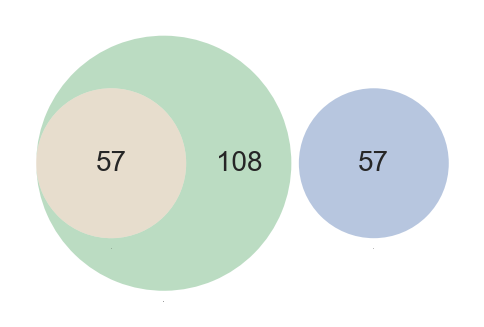

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# =========================
# LOAD DATA
# =========================
df_main = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_plaque_comparison/results/Significant_down_genes_sortedbyp_plaqueANDoligo.csv")   # must contain column "gene_id"
df_oligo = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_correlation/Oligo_Genes.csv")
df_plaque = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_correlation/Plaque_Genes.csv")

# =========================
# EXTRACT GENE SETS
# =========================
genes_main = set(df_main["gene_id"].dropna().astype(str))
genes_oligo = set(df_oligo["Name"].dropna().astype(str))
genes_plaque = set(df_plaque["Name"].dropna().astype(str))

# =========================
# VENN DIAGRAM
# =========================
plt.figure(figsize=(6, 6))

plt = venn3(
    [genes_main, genes_oligo, genes_plaque]
    #set_labels=("Up-regulated genes", "Oligo genes", "Plaque genes")
)

# Adjust font size for the set labels (outside the circles)
for text in plt.set_labels:
    if text: # Ensure the label exists before trying to set its property
        text.set_fontsize(1) # Set your desired font size

# Adjust font size for the subset labels (inside the circles)
for text in plt.subset_labels:
    if text: # Ensure the label exists before trying to set its property
        text.set_fontsize(20) # Set your desired font size

# plt.title("Gene overlap between input, Oligo, and Plaque")
plt.tight_layout()
plt.savefig("venn_down.png", dpi=300)
plt.show()


  Using cached matplotlib-venn-1.1.2.tar.gz (40 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45388 sha256=28c7644b0d267c5c7a112ff81ddf4a1e7e80481d2b73ca175131b51e959d9698
  Stored in directory: /Users/wanglab_super1/Library/Caches/pip/wheels/c4/16/4a/93374cd955bbe0553a8ce74db7f0fbd5fcc876e19fb78bd601
Successfully built matplotlib-venn

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
